Libraries

In [1]:
from __future__ import division
from bisect import bisect_right
from heapq import heappop, heappush
from collections import defaultdict 


import string
import math
import os
import re
import random
import time
import binascii
import csv
import pandas as pd
import matplotlib.pyplot as plt
import re
import math
from itertools import chain
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.util import ngrams # This is the ngram magic.
from textblob import TextBlob
import numpy as np


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Open Dataset

In [2]:
def openDataset(dataFile):
  documents = []
  with open(dataFile) as csvDataFile:
      csvReader = csv.reader(csvDataFile)
      next(csvReader)
      for row in csvReader:
          documents.append(row)
  csvDataFile.close()
  return documents

## Jaccard similarity - Ground truth

In [4]:
def pre_processing(word):
  punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  word = word.lower()
  char = word[len(word)-1]
  no_punct = word
  
  # remove punctuation from the string
  if char in punctuations:
    no_punct = word[:-1]

  return no_punct

In [5]:
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

def get_tuples_nosentences(txt):
    if not txt: return None
    ng = ngrams(re.sub(r'[^a-zA-Z0-9\s]',' ', txt.lower()).split(),3)
    return list(ng)
    
def jaccard_similarity(a, b):
    a = set(a)
    b = set(b)
    return 1.0 * len(a&b)/len(a|b)

In [6]:
def plotValues(list_weight_all):
  plt.yscale('log', nonposy = 'clip')
  plt.title('Number of documents in function of their similarity with each other')
  plt.xlabel('Similarty between documents')
  plt.ylabel('Number of documents')
  plt.hist(list_weight_all, bins = [0,0.10,0.20,0.30,0.4,0.5,0.6,0.7,0.8,0.9,1])

def shinglesDoc(documents):
  list_text = [item[1] for item in documents]
  shingles_documents = [get_tuples_nosentences(d) for d in list_text]
  return shingles_documents
  
def createDataset(list_doc1,list_doc2,weights):
  df = pd.DataFrame(columns=["Doc1","Doc2","Value"])
  df["Doc1"] = list_doc1
  df["Doc2"] = list_doc2
  df["Value"] = weights
  return df

def doc_jaccard(preprocessed_documents):
  i = 0
  list_weight_all = []
  list_doc1 = []
  list_doc2 = []
  weights = []

  for  base_sen in preprocessed_documents:
    j = 0
    for compare_sen in preprocessed_documents:
      if i > j:
        wj = jaccard_similarity(base_sen,compare_sen)
        list_weight_all.append(wj)
        weights.append(wj)
        list_doc1.append(i)
        list_doc2.append(j)
      j = j+1
    i = i+1

  return createDataset(list_doc1,list_doc2,weights), list_weight_all

## Shingles and MinHash implementation

In [7]:
def docsShingles(documents):
  docsID = []
  docsShingleSets = {}
  totalShingles = 0
  
  for doc in documents:
    words = doc[1].split(" ")
    docID = doc[0]
    docsID.append(docID)

    docShingles = set()
    
    for index in range(0, len(words) - 2):
      shingle = pre_processing(words[index]) + " " + pre_processing(words[index + 1]) + " " + pre_processing(words[index + 2])
      shingle = str.encode(shingle)
      crc = binascii.crc32(shingle) & 0xffffffff
      docShingles.add(crc)
    
    docsShingleSets[docID] = docShingles
    totalShingles = totalShingles + (len(words) - 2)
  
  return docsID, docsShingleSets, totalShingles

In [8]:
def pickRandomCoeffs(k, maxShingleID):
  randList = []
  
  while k > 0:
    randIndex = random.randint(0, maxShingleID) 

    while randIndex in randList:
      randIndex = random.randint(0, maxShingleID) 

    randList.append(randIndex)
    k = k - 1
    
  return randList

In [9]:
def minHash(numHashes):
  
  maxShingleID = 2**32-1
  nextPrime = 4294967311 # Next prime number to maxShingleID

  coeffA = pickRandomCoeffs(numHashes, maxShingleID)
  coeffB = pickRandomCoeffs(numHashes, maxShingleID)

  signatures = []

  for docID in docsID:
    shingleSet = docsShingleSets[docID]
    signature = []

    for i in range(0, numHashes):
      minHashCode = nextPrime + 1
    
      for shingleID in shingleSet:
        hashCode = (coeffA[i] * shingleID + coeffB[i]) % nextPrime 
      
        if hashCode < minHashCode:
          minHashCode = hashCode

      signature.append(minHashCode)
    
    signatures.append(signature)
  
  return signatures

## LSH implementation

In [10]:
def similarDocs(signatures,r,b):
  lsh = []
  len(signatures)
  for s in range(len(signatures)):
      sig = signatures[s]
      for i, band in enumerate(range(b)):
          lsh.append(hash(tuple(sig[i*r:i*r+r])))

  lsh_arr = np.array(lsh).reshape(L,b) # convert lsh from a list to a array of shape n-by-b  
  hashmap = [defaultdict(list) for i in range(b)]

  for j in range(b):
      lsh_b = lsh_arr[:,j]
      n = lsh_arr.shape[0]
      for i in range(n):
          hashmap[j][lsh_b[i]].append(i) 
  
  return hashmap

In [11]:
def createListCandidates(hashmap):
  list_candidate = []
  
  for key in hashmap[0]:
    list_key = hashmap[0][key]
    
    if len(list_key) > 1:
      list_app = list_key
      
      while len(list_app) > 1:
        first = list_app[0]
        list_app.pop(0)
        
        for i in list_app:
          app = []
          app.append(first)
          app.append(i)
          app.sort()
          list_candidate.append(app)
  
  return list_candidate

## Main

In [ ]:
dataFile = "news_articles_small.csv" 
documents = openDataset(dataFile)

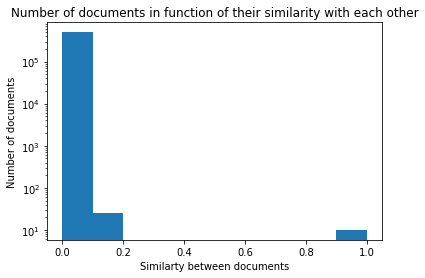

In [ ]:
preprocessed_documents = shinglesDoc(documents)
jaccardGT, list_weight_all = doc_jaccard(preprocessed_documents)
dataframe_plagiared_gt = jaccardGT.loc[(jaccardGT["Value"] > 0.8)]
plotValues(list_weight_all)

In [ ]:
dataframe_plagiared_gt

,Doc1,Doc2,Value
21013,205,103,0.979757
69576,373,198,0.979920
115111,480,151,0.980769
136625,523,122,0.981413
147893,544,197,0.980620
278174,746,289,0.982206
299523,774,372,0.981752
321533,802,332,0.977679
387024,880,264,0.981413
421185,918,282,0.983051


In [ ]:
docsID, docsShingleSets, totalShingles = docsShingles(documents)
L = 1000

In [ ]:
# Function that computes LSH on the documents of the small dataset
def run(numHashes, r_list, b_list):
  signatures = minHash(numHashes)
  tp_l=[]
  fp_l=[]
  fn_l=[]
  t_l=[]
  
  for i in range(0,len(r_list)):
  
    r = r_list[i] # Number of rows in each band
    b = b_list[i] # Number of bands
    t = (1. / b) ** (1. / r) # Threshold  value

    print("Case:", i)
    print("b:", b)
    print("r:", r)
    print("t:", t, "\n")

    hashmap = similarDocs(signatures,r,b)
    list_candidate = createListCandidates(hashmap)
    
    dataframe_plagiared = pd.DataFrame.from_records(list_candidate)
    dataframe_plagiared = dataframe_plagiared.rename(columns = {1: 'Doc1', 0:'Doc2'})
    
    tp = pd.merge(dataframe_plagiared, dataframe_plagiared_gt, how='inner', on=['Doc1',"Doc2"])
    tp_len = len(tp)
    
    fp = pd.merge(dataframe_plagiared, dataframe_plagiared_gt, on=['Doc1','Doc2'],how='left',indicator="Exist")
    fp = fp.loc[fp['Exist'] == "left_only" ]
    fp_len = len(fp)
    
    fn = pd.merge(dataframe_plagiared_gt,dataframe_plagiared, on=['Doc1','Doc2'],how='left',indicator="Exist")
    fn = fn.loc[fn['Exist'] == "left_only" ]
    fn_len = len(fn)

    tp_l.append(tp_len)
    fp_l.append(fp_len)
    fn_l.append(fn_len)
    t_l.append(t)

  print(tp_l)
  print(fp_l)
  print(fn_l)
  print("\n")

##Experiments

In [ ]:
def plotExperiments(numHash, r, b):
  fig, ax1 = plt.subplots()
  x = np.linspace(0,1,100)

  y1 = 1-(1-x**r[0])**b[0]
  y2 = 1-(1-x**r[1])**b[1]
  y3 = 1-(1-x**r[2])**b[2]
  y4 = 1-(1-x**r[3])**b[3]
  y5 = 1-(1-x**r[4])**b[4]
  y6 = 1-(1-x**r[5])**b[5]
  
  color = 'tab:blue'
  
  plt.yscale('log', nonposy = 'clip')
  plt.title('Number of documents in function of their similarity with each other')
  plt.xlabel('Similarty between documents')
  plt.ylabel('Number of documents')
  
  ax1.hist(list_weight_all, bins = [0,0.10,0.20,0.30,0.4,0.5,0.6,0.7,0.8,0.9,1])
  ax1.tick_params(axis='y', labelcolor=color)
  ax2 = ax1.twinx()

  color = 'tab:red'
  
  ax2.set_ylabel('Probability', color=color) 

  lab1 = "b: " + str(b[0]) + " r: " + str(r[0])
  lab2 = "b: " + str(b[1]) + " r: " + str(r[1])
  lab3 = "b: " + str(b[2]) + " r: " + str(r[2])
  lab4 = "b: " + str(b[3]) + " r: " + str(r[3])
  lab5 = "b: " + str(b[4]) + " r: " + str(r[4])
  lab6 = "b: " + str(b[5]) + " r: " + str(r[5])

  ax2.plot(x,y1,label = lab1)
  ax2.plot(x,y2,label = lab2)
  ax2.plot(x,y3,label = lab3)
  ax2.plot(x,y4,label = lab4)
  ax2.plot(x,y5,label = lab5)
  ax2.plot(x,y6,label = lab6)
  plt.ylim(ymin=0)
  ax2.tick_params(axis='y', labelcolor=color)

  plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")

  fig.tight_layout() 
  plt.show()

In [ ]:
# Function that calculates the value of p2 with threshold s2 = 0.8
def print_prob(numHashes, r, b):
  y1 = 1-(1-(0.8**r[0]))**b[0]
  y2 = 1-(1-(0.8**r[1]))**b[1]
  y3 = 1-(1-(0.8**r[2]))**b[2]
  y4 = 1-(1-(0.8**r[3]))**b[3]
  y5 = 1-(1-(0.8**r[4]))**b[4]
  y6 = 1-(1-(0.8**r[5]))**b[5]

  print("num. of hash: " + str(numHashes))
  print("b: " + str(b[0]) + " r: " + str(r[0]) + " prob.: " + str(y1))
  print("b: " + str(b[1]) + " r: " + str(r[1]) + " prob.: " + str(y2))
  print("b: " + str(b[2]) + " r: " + str(r[2]) + " prob.: " + str(y3))
  print("b: " + str(b[3]) + " r: " + str(r[3]) + " prob.: " + str(y4))
  print("b: " + str(b[4]) + " r: " + str(r[4]) + " prob.: " + str(y5))
  print("b: " + str(b[5]) + " r: " + str(r[5]) + " prob.: " + str(y6))

# Function that calculates the value of p1 with threshold s2 = 0.5, 0.6 and 0.7
def print_prob_p1(numHashes, r, b, p1):
  y1 = 1-(1-(p1**r[0]))**b[0]
  y2 = 1-(1-(p1**r[1]))**b[1]
  y3 = 1-(1-(p1**r[2]))**b[2]
  y4 = 1-(1-(p1**r[3]))**b[3]
  y5 = 1-(1-(p1**r[4]))**b[4]

  print("Probability: " + str(p1))
  print("num. of hash: " + str(numHashes[0]))
  print("b: " + str(b[0]) + " r: " + str(r[0]) + " prob.: " + str(y1))
  print("num. of hash: " + str(numHashes[1]))
  print("b: " + str(b[1]) + " r: " + str(r[1]) + " prob.: " + str(y2))
  print("num. of hash: " + str(numHashes[2]))
  print("b: " + str(b[2]) + " r: " + str(r[2]) + " prob.: " + str(y3))
  print("num. of hash: " + str(numHashes[3]))
  print("b: " + str(b[3]) + " r: " + str(r[3]) + " prob.: " + str(y4))
  print("num. of hash: " + str(numHashes[4]))
  print("b: " + str(b[4]) + " r: " + str(r[4]) + " prob.: " + str(y5))

In [ ]:
# First case with 20 hash functions
numHashes = 20
r_list = [5,4,2,1,10,20]
b_list = [4,5,10,20,2,1]

run(numHashes, r_list, b_list)
plotExperiments(numHashes, r_list, b_list)
print_prob(numHashes, r_list, b_list)

In [ ]:
# Second case with 24 hash functions
numHashes = 24
r_list = [4,6,12,2,24,1]
b_list = [6,4,2,12,1,24]

run(numHashes, r_list, b_list)
plotExperiments(numHashes, r_list, b_list)
print_prob(numHashes, r_list, b_list)

In [ ]:
# Third case with 30 hash functions
numHashes = 30
r_list = [5,6,3,1,10,30]
b_list = [6,5,10,30,3,1]

run(numHashes, r_list, b_list)
plotExperiments(numHashes, r_list, b_list)
print_prob(numHashes, r_list, b_list)

In [ ]:
# Fourth case with 36 hash functions
numHashes = 36
r_list = [4,9,2,1,18,36]
b_list = [9,4,18,36,2,1]

run(numHashes, r_list, b_list)
plotExperiments(numHashes, r_list, b_list)
print_prob(numHashes, r_list, b_list)

In [ ]:
# Fifth case with 40 hash functions
numHashes = 40
r_list = [5,8,4,1,10,40]
b_list = [8,5,10,40,4,1]

run(numHashes, r_list, b_list)
plotExperiments(numHashes, r_list, b_list)
print_prob(numHashes, r_list, b_list)

In [ ]:
# Tests of the best lower bound for the tollerance zone with the best results computed 
numHashes = [20,24,30,36,40]
b_list = [5,4,6,9,8]
r_list = [4,6,5,4,5]

p1 = 0.70
print_prob_p1(numHashes, r_list, b_list, p1)
print("---")
p1 = 0.60
print_prob_p1(numHashes, r_list, b_list, p1)
print("---")
p1 = 0.50
print_prob_p1(numHashes, r_list, b_list, p1)

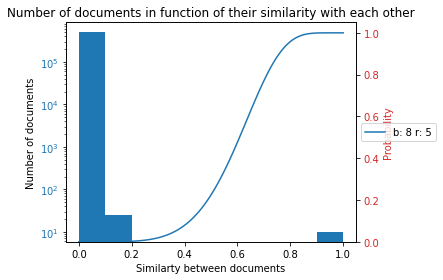

In [ ]:
# Printing final graph with the best results
fig, ax1 = plt.subplots()
x = np.linspace(0,1,100)

y1 = 1-(1-x**5)**8

color = 'tab:blue'
  
plt.yscale('log', nonposy = 'clip')
plt.title('Number of documents in function of their similarity with each other')
plt.xlabel('Similarty between documents')
plt.ylabel('Number of documents')
  
ax1.hist(list_weight_all, bins = [0,0.10,0.20,0.30,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  

color = 'tab:red'

ax2.set_ylabel('Probability', color=color) 

lab1 = "b: 8 r: 5"
ax2.plot(x,y1,label = lab1)

plt.ylim(ymin=0)
ax2.tick_params(axis='y', labelcolor=color)

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")

fig.tight_layout()  
plt.show()

## Big dataset

In [12]:
# Custom function that calculates LSH on the big dataset with the best parameters found
def run_large(numHashes, r_list, b_list):
  signatures = minHash(numHashes)
  tp_l=[]
  fp_l=[]
  fn_l=[]
  t_l=[]
  
  for i in range(0,len(r_list)):
    r = r_list[i]
    b = b_list[i]
    t = (1. / b) ** (1. / r)

    print("Best Case")
    print("r:", r)
    print("b:", b)
    print("t:", t, "\n")

    hashmap = similarDocs(signatures,r,b)
    list_candidate = createListCandidates(hashmap)
  
  return list_candidate

In [19]:
dataFile = "news_articles_large.csv" 
documents = openDataset(dataFile)

In [20]:
docsID, docsShingleSets, totalShingles = docsShingles(documents)
L = 10000 

In [ ]:
numHashes = 40
b_list = [8]
r_list = [5]
list_candidate=run_large(numHashes,r_list,b_list)

In [22]:
list_doc0=[]
list_doc1=[]

# Function that computes the Jaccard similarity only on the candidate pairs and takes the documents only with similarity > 0.8
for i in list_candidate:
  doc0 = documents[i[0]][1]
  doc1 = documents[i[1]][1]
  tokenize = lambda doc: doc.lower().split(" ")
  doc0_shingled = get_tuples_nosentences(doc0)
  doc1_shingled = get_tuples_nosentences(doc1)
  jaccard = jaccard_similarity(doc0_shingled,doc1_shingled)

  if jaccard > 0.8:
    list_doc0.append(i[0])
    list_doc1.append(i[1])

In [23]:
# Save the documents found into a csv file
pair_doc=pd.DataFrame(columns = ['doc_id1','doc_id2'])
pair_doc["doc_id1"] = list_doc0
pair_doc["doc_id2"] = list_doc1
pair_doc.to_csv("result.csv",index = False)